# Demo of e-valuator

In this notebook, we demonstrate how to use our package to apply to a dataset (HotpotQA). We require the user to input a (calibration) dataframe of agent trajectories with the following columns:

* `uq_problem_idx`: A unique identifier for each problem. Multiple rows will correspond to the same trajectory, so this is an identifier of the problem.
* `num_steps`: Number of steps taken in the trajectory thus far.
* `judge_probability`: Verifier score for that step in that trajectory.
* `solved`: A binary indicator (0/1) of whether that problem was (eventually) solved by the agent. This column is only required during calibration time.

You may use different names for the columns, in which case you'll have to specify in your function arguments the variable names. For instance, you'd have to change the `prob_col`, `problem_col`, and `step_col` arguments of this function:

```
add_judge_probability_series(
    df: pd.DataFrame,
    prob_col: str = "judge_probability",
    problem_col: str = "problem_idx",
    step_col: str = "num_steps",
)
```
Note: the judge/verifier used in `hotpotqa_w_scores_compressed.csv.gz` was Claude, the agent used was Aviary from FutureHouse.
Let's get started!


In [ ]:
import pandas as pd
import numpy as np


## import the package
import evaluator as e_val

csv_path = "../../data/hotpotqa_w_scores_compressed.csv.gz"


In [5]:
## load in the raw data
df = pd.read_csv(csv_path)


print("Loaded:", df.shape)
print(df.columns)


## add a column of concatenated verifier scores
## note: this step takes some time
df = e_val.utils.add_judge_probability_series(df)
df.head()


Loaded: (75880, 5)
Index(['Unnamed: 0', 'uq_problem_idx', 'num_steps', 'judge_probability',
       'solved'],
      dtype='object')


Building judge_probability_series:   0%|          | 0/75880 [00:00<?, ?it/s]

Building judge_probability_series: 100%|██████████| 75880/75880 [05:13<00:00, 242.28it/s]


,Unnamed: 0,uq_problem_idx,num_steps,judge_probability,solved,judge_probability_series
0,0,hotpotqa_0,1,0.40,True,[0.4]
1,1,hotpotqa_0,2,0.75,True,"[0.4, 0.75]"
2,2,hotpotqa_1,1,0.50,True,[0.5]
3,3,hotpotqa_1,2,0.70,True,"[0.5, 0.7]"
4,4,hotpotqa_1,3,0.85,True,"[0.5, 0.7, 0.85]"


Now that we have our dataframe set up, let's split it into calibration and test set. In general, you can load in different dataframes for calibration and test, but in this notebook we generate them as splits of the same set. Note that a single problem must be fully in either test or calibration (e.g., no instances where steps 1-2 are in calibration and 3-4 are in test).

In [6]:
## get list of all unique problem indices
unique_ids = df["uq_problem_idx"].unique()
rng = np.random.default_rng(42)

# 80/20 split of calibration and test set
n_cal = int(0.8 * len(unique_ids))
cal_ids = rng.choice(unique_ids, size=n_cal, replace=False)
test_ids = np.setdiff1d(unique_ids, cal_ids)


## split into calibration and test set
cal_df = df[df["uq_problem_idx"].isin(cal_ids)].reset_index(drop=True)
test_df = df[df["uq_problem_idx"].isin(test_ids)].reset_index(drop=True)

print("Calibration:", cal_df.shape, "Unique problems:", len(cal_ids))
print("Test:", test_df.shape, "Unique problems:", len(test_ids))


Calibration: (60725, 6) Unique problems: 12888
Test: (15155, 6) Unique problems: 3222


Now we'll fit our density ratio estimators. By default, we recommend logistic regression, which can be specified with `model_type="logistic"` as we do below. However, we also support random forests and plan to support other DRE methods in the future. You may also modify `evaluator.py` to change the density ratio estimation procedure (e.g., add L2 penalty to the Logistic Regression).

In [7]:
ev = e_val.EValuator(
    model_type="logistic",   
    mt_variant="both",    ## "split" is finite time/empirical version of e-valuator. "anytime" is the anytime-valid version. "both" adds both the finite-time and empirical versions as columns to the test set.
    alphas=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ## by default, alphas = [0.05] unless otherwise specified, as we do here
    # delta=0.1, ## only used for split version, confidence level in false alarm guarantee. default is 0.1 (meaning 90% confidence in false alarm guarantee)
    delta=0.05,
)

ev


In [8]:
ev.fit(cal_df)


In [9]:
## apply the learned density ratio estimators to the test set
test_df = ev.apply(test_df)

In [10]:
## let's look at at the statistics
## note anytime eval and split eval will be different because split eval splits the calibration set into two parts
test_df[["uq_problem_idx", "num_steps", "solved"] + [c for c in test_df.columns if "e_val" in c]]


,uq_problem_idx,num_steps,solved,anytime_e_val,split_e_val
0,hotpotqa_2,1,False,1.614051,1.599212
1,hotpotqa_2,2,False,1.020116,1.014685
2,hotpotqa_2,3,False,1.790568,1.787716
3,hotpotqa_2,4,False,2.230558,2.220886
4,hotpotqa_2,5,False,0.447616,0.452647
...,...,...,...,...,...
15150,hotpotqa_16106,3,False,1.045660,1.054207
15151,hotpotqa_16106,4,False,2.118731,2.126032
15152,hotpotqa_16106,5,False,3.147716,3.269763
15153,hotpotqa_16106,6,False,2.552018,2.468352


Ok, we are done! Let's see how our e-valuator performed on this test set.

Mean maximum among solved problems: 1.563275614736237
Mean maximum among unsolved problems: 9.350380728893787


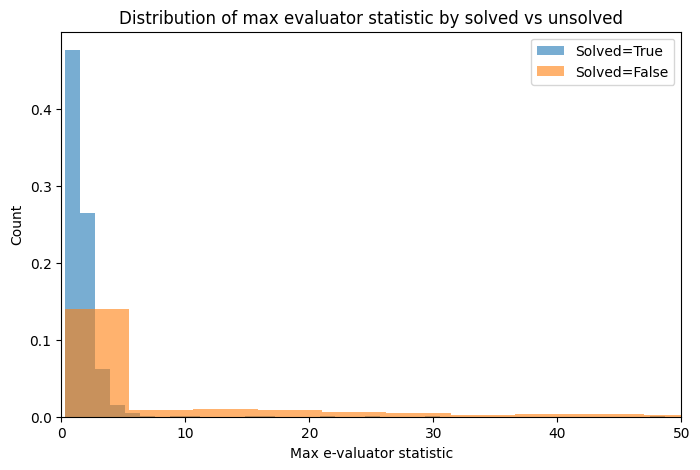

In [11]:
import matplotlib.pyplot as plt

## let's use the empirical version
stat_col = "split_e_val"

grouped = test_df.groupby("uq_problem_idx")
problem_max = grouped[stat_col].max()
problem_solved = grouped["solved"].max()

max_solved = problem_max[problem_solved == 1]
max_unsolved = problem_max[problem_solved == 0]

print("Mean maximum among solved problems:", max_solved.mean())
print("Mean maximum among unsolved problems:", max_unsolved.mean())

plt.figure(figsize=(8,5))
plt.hist(max_solved, bins=40, alpha=0.6, label="Solved=True", density=True)
plt.hist(max_unsolved, bins=40, alpha=0.6, label="Solved=False", density=True)
plt.xlim(0, 50)
plt.xlabel("Max e-valuator statistic")
plt.ylabel("Count")
plt.title("Distribution of max evaluator statistic by solved vs unsolved")
plt.legend()
plt.show()


In [12]:
## extract thresholds for anytime and split variants
thresholds = ev.thresholds

## let's look at the thresholds for the split variant
print(thresholds["split"])

## let's look at the thresholds for the anytime variant
print(thresholds["anytime"])


{0.01: 6.486116170771263, 0.05: 3.4111957821647083, 0.1: 2.6460922565523974, 0.2: 2.073692055005295, 0.3: 1.7101687787815916, 0.4: 1.5992116825462215, 0.5: 1.1866486700178034}
{0.01: 100.0, 0.05: 20.0, 0.1: 10.0, 0.2: 5.0, 0.3: 3.3333333333333335, 0.4: 2.5, 0.5: 2.0}


In [13]:
results_anytime = {}
results_split = {}

## One label per problem
problem_solved = (
    test_df.groupby(ev.problem_col)["solved"]
           .max()
           .astype(int)
)

for a in ev.alphas:
    base = str(a).replace(".", "_")
    col_any = f"reject_anytime_alpha_{base}"
    col_split = f"reject_split_alpha_{base}"

    ## "Ever rejected" for each problem
    reject_any = (
        test_df.groupby(ev.problem_col)[col_any]
               .max()
               .astype(bool)
    )
    reject_split = (
        test_df.groupby(ev.problem_col)[col_split]
               .max()
               .astype(bool)
    )

    ## power: pr(reject|solved == 0)
    ## false alarm rate: pr(reject|solved == 1)
    power_any = reject_any[problem_solved == 0].mean()
    fa_any = reject_any[problem_solved == 1].mean()

    power_split = reject_split[problem_solved == 0].mean()
    fa_split = reject_split[problem_solved == 1].mean()

    results_anytime[a] = (power_any, fa_any)
    results_split[a] = (power_split, fa_split)

print("=== Problem-level Evaluation (anytime) ===")
for a, (power, fa) in results_anytime.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")

print("\n=== Problem-level Evaluation (split) ===")
for a, (power, fa) in results_split.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")


=== Problem-level Evaluation (anytime) ===
alpha=0.010 | power=0.0201 | false alarm rate=0.0000
alpha=0.050 | power=0.2045 | false alarm rate=0.0037
alpha=0.100 | power=0.2553 | false alarm rate=0.0055
alpha=0.200 | power=0.2955 | false alarm rate=0.0154
alpha=0.300 | power=0.3896 | false alarm rate=0.0534
alpha=0.400 | power=0.5395 | false alarm rate=0.1235
alpha=0.500 | power=0.6399 | false alarm rate=0.2064

=== Problem-level Evaluation (split) ===
alpha=0.010 | power=0.2610 | false alarm rate=0.0068
alpha=0.050 | power=0.3670 | false alarm rate=0.0461
alpha=0.100 | power=0.5119 | false alarm rate=0.1063
alpha=0.200 | power=0.6305 | false alarm rate=0.1984
alpha=0.300 | power=0.6957 | false alarm rate=0.2918
alpha=0.400 | power=0.7045 | false alarm rate=0.3120
alpha=0.500 | power=0.8312 | false alarm rate=0.5055
